# Import Library

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics
import glob
import csv
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
interesting_dir = "./Data/Fastest/"
#interesting_files = ["sit.csv", "stand.csv", "walk.csv"]
interesting_labels = ['stand', 'walk','jump','fall']
save_filename = "activity"

Default GPU Device: /device:GPU:0


# Concate and label the raw data  

In [172]:
def data_concate_label(path,label):
    all_files1 = glob.glob(path + "/*.csv")
    
    li = []

    for filename in all_files1:
        df = pd.read_csv(filename, index_col=None, header=0)
        
        if 'label' in df.columns:
            pass
        else:df['label'] = str(label)
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
#     frame = frame.drop_duplicates()
    
    if len(df.columns) == 19 :
        new_header =['DATE','TIME','ax','ay','az','gx','gy','gz','lx','ly','lz','mx','my','mz','ma','mg','ml','mm','label']
    
    else :
       
        new_header =['DATE','TIME','ax','ay','az','gx','gy','gz','ma','mg','label']
#     if label == 'fall':
#         frame = frame.drop_duplicates()
        
#         frame = frame.query("mg >= 10 ")
#     if label =='jump':
        
#         frame = frame.query("mg <= 6")
    
#     else : pass
    frame = frame[1000:16000]
    
    print(frame.shape)
    print(len(df.columns))
    frame.to_csv("./Data/Fastest/activity_"+str(label)+".csv",index = False,header=new_header)
    

In [200]:
path1 = r".\Data\Fastest\stand"
label1 = "stand"
path2 = r".\Data\Fastest\walk"
label2 = "walk"
path3 = r".\Data\Fastest\jump"
label3 = "jump"
path4 = r".\Data\Fastest\Fall"
label4 = "fall"
data_concate_label(path1,label1)
data_concate_label(path2,label2)
data_concate_label(path3,label3)
data_concate_label(path4,label4)

(14320, 11)
11
(15000, 11)
11
(15000, 11)
11
(15000, 11)
11


# Concate all data into one .csv file

In [221]:
import copy

df = pd.DataFrame()
for i in range(len(interesting_labels)):
#     df_tmp = pd.read_csv(interesting_dir+save_filename+"_"+str(i+1)+'.csv',parse_dates=[['DATE', ' TIME']],header = 0)
    df_tmp = pd.read_csv(interesting_dir+save_filename+"_"+interesting_labels[i]+'.csv',header = 0)
    df = pd.concat([df, df_tmp])
    
print(len(df.columns))
# df['ts'] = df[['DATE_TIME']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
# df = df.assign(DATE_TIME=df['ts'])
# if len(df.columns) == 19 :
drop_list = ['DATE','TIME','mg','gx','gy','gz',]
# else :pass

# drop_list = ['DATE','TIME','ma','mg']
df = df.drop(drop_list, axis=1)
df = df.dropna()

# df.rename(columns = {'DATE_TIME':'ts'}, inplace = True) 
all_data_filename = "total.csv"
df.to_csv(interesting_dir+all_data_filename)

# df.reset_index(inplace = True) 
df

11


ax        ay        az        ma  label
0     -8.715476 -4.610413  0.946033  9.905070  stand
1     -8.710687 -4.557723  0.977168  9.879461  stand
2     -8.710687 -4.557723  0.977168  9.879461  stand
3     -8.725057 -4.447551  0.946033  9.838816  stand
4     -8.725057 -4.447551  0.946033  9.838816  stand
...         ...       ...       ...       ...    ...
14995 -1.533799  0.641277  8.563912  8.723782   fall
14996 -1.469193  0.636491  8.702696  8.848761   fall
14997 -1.469193  0.636491  8.702696  8.848761   fall
14998 -1.227518  0.701097  8.896515  9.008125   fall
14999 -1.227518  0.701097  8.896515  9.008125   fall

[59320 rows x 5 columns]

# Feature correlation (optional)

In [222]:
# use deepcopy to avoid other operation change value of df
df_cor = copy.deepcopy(df) 

features = df_cor.columns[0:-1]
df_cor["label"] = pd.factorize(df_cor.label)[0]
traindf = pd.DataFrame(df_cor,columns=features)
#print(df_cor["label"])
#print(traindf)

feature_name = list(traindf.columns)
print(feature_name)
y = df_cor['label']
X = traindf.copy()
X.isna().sum()
# X.dropna()
# X.fillna('mean')

['ax', 'ay', 'az', 'ma']


ax    0
ay    0
az    0
ma    0
dtype: int64

[0.25502158 0.24835375 0.26615856 0.23046611]


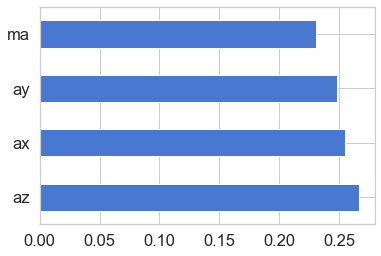

In [223]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

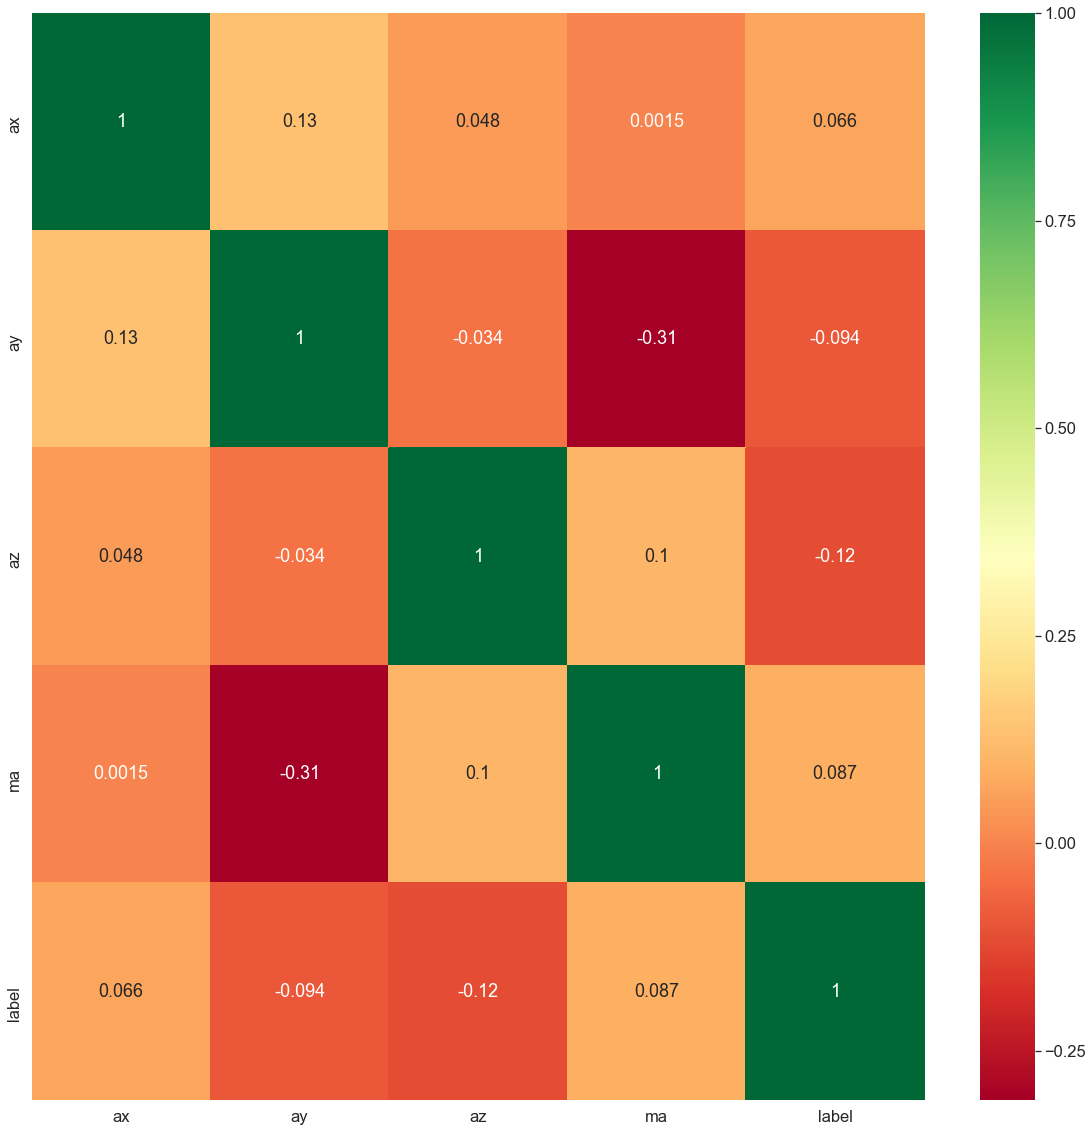

In [224]:
#get correlations of each features in dataset

corrmat = df_cor.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cor[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [225]:
num_feats= len(feature_name)
X.columns.tolist()

['ax', 'ay', 'az', 'ma']

In [226]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
   
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    return cor_support, cor_feature, cor_list

cor_support, cor_feature, cor_list = cor_selector(X, y,num_feats)
cor_val=[abs(x) for x in cor_list]
cor_result = dict(zip(cor_feature, cor_val))
myDict = {key:val for key, val in cor_result.items() if val > 0}
{k: v for k, v in sorted(myDict.items(),reverse=True, key=lambda item: item[1])}

{'ay': 0.11960174848711998,
 'ma': 0.09375814389797371,
 'az': 0.08672049612902309,
 'ax': 0.06579295359267671}

In [227]:
df_plot = copy.deepcopy(df)
df_plot.reset_index(inplace = True) 


       index         ax        ay        az         ma label
45320   1000 -10.102497 -2.120041  7.118648  12.539145  fall
45321   1001 -10.102497 -2.120041  7.118648  12.539145  fall
45322   1002  -9.901500 -2.220539  7.482356  12.607781  fall
45323   1003  -9.901500 -2.220539  7.482356  12.607781  fall
45324   1004  -9.774680 -2.287539  8.051848  12.868934  fall
...      ...        ...       ...       ...        ...   ...
49315   4995   1.385444 -6.022735  7.477571   9.700868  fall
49316   4996   1.320838 -5.984449  7.523035   9.703314  fall
49317   4997   1.320838 -5.984449  7.523035   9.703314  fall
49318   4998   1.280160 -6.017949  7.578069   9.761232  fall
49319   4999   1.280160 -6.017949  7.578069   9.761232  fall

[4000 rows x 6 columns]
fall


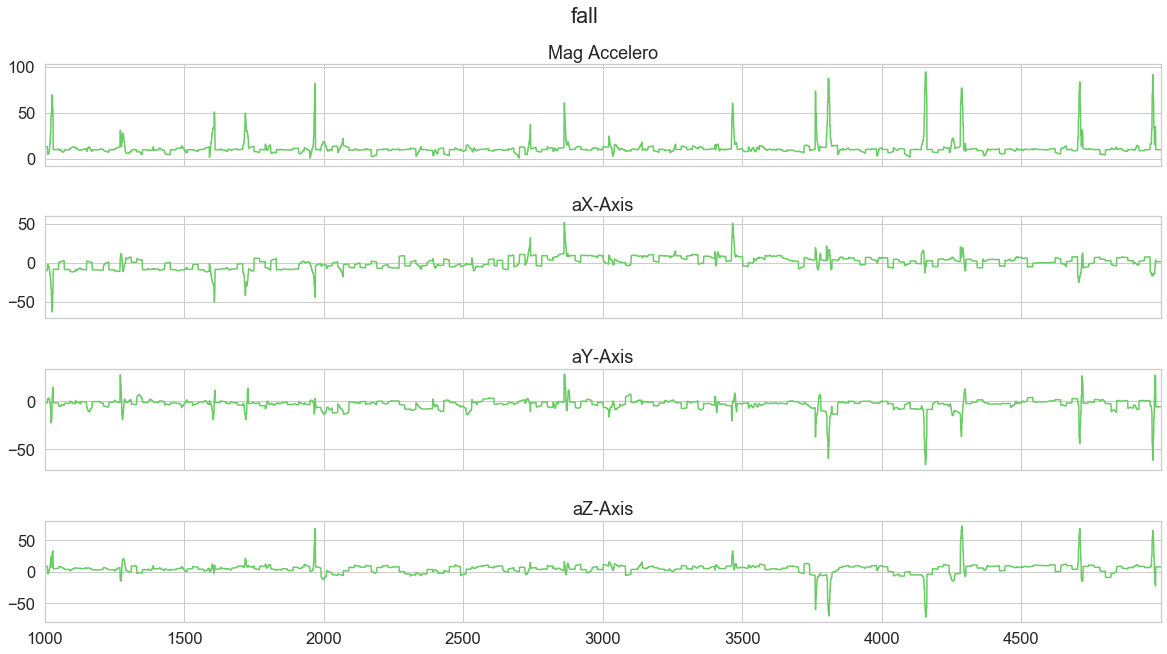

       index        ax        ay        az        ma label
15320   1000  7.884351 -2.629712  4.826323  9.611023  walk
15321   1001  7.779067 -2.557927  4.749753  9.466627  walk
15322   1002  7.779067 -2.557927  4.749753  9.466627  walk
15323   1003  7.690532 -2.483750  4.687540  9.342715  walk
15324   1004  7.690532 -2.483750  4.687540  9.342715  walk
...      ...       ...       ...       ...       ...   ...
19315   4995  3.771089 -1.105484  7.082755  8.099915  walk
19316   4996  3.565306 -1.060020  6.920043  7.856338  walk
19317   4997  3.565306 -1.060020  6.920043  7.856338  walk
19318   4998  3.318845 -1.009771  6.790831  7.625598  walk
19319   4999  3.318845 -1.009771  6.790831  7.625598  walk

[4000 rows x 6 columns]
walk


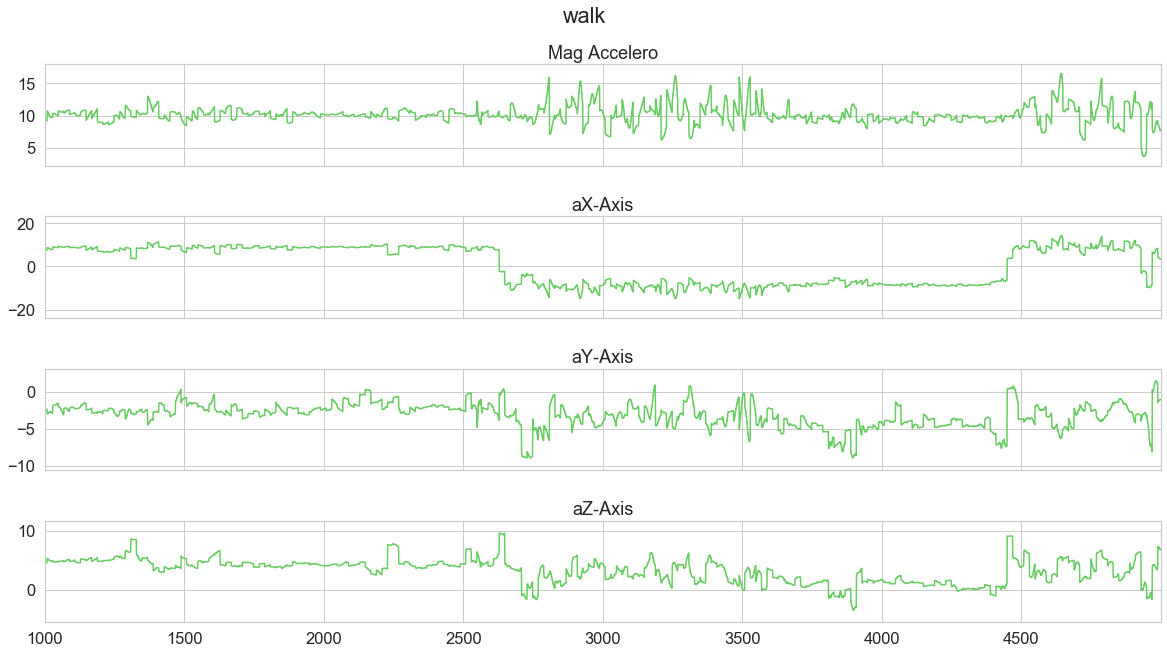

       index        ax        ay        az         ma label
30320   1000 -4.299902  1.624726  1.667797   4.889831  jump
30321   1001 -4.393222  1.727618  1.873580   5.078914  jump
30322   1002 -4.393222  1.727618  1.873580   5.078914  jump
30323   1003 -4.340580  1.653441  2.153540   5.119789  jump
30324   1004 -4.340580  1.653441  2.153540   5.119789  jump
...      ...       ...       ...       ...        ...   ...
34315   4995 -8.817552 -4.474578  4.426722  10.833602  jump
34316   4996 -8.571091 -4.503292  4.654040  10.742594  jump
34317   4997 -8.571091 -4.503292  4.654040  10.742594  jump
34318   4998 -8.305488 -4.520042  4.960321  10.677860  jump
34319   4999 -8.305488 -4.520042  4.960321  10.677860  jump

[4000 rows x 6 columns]
jump


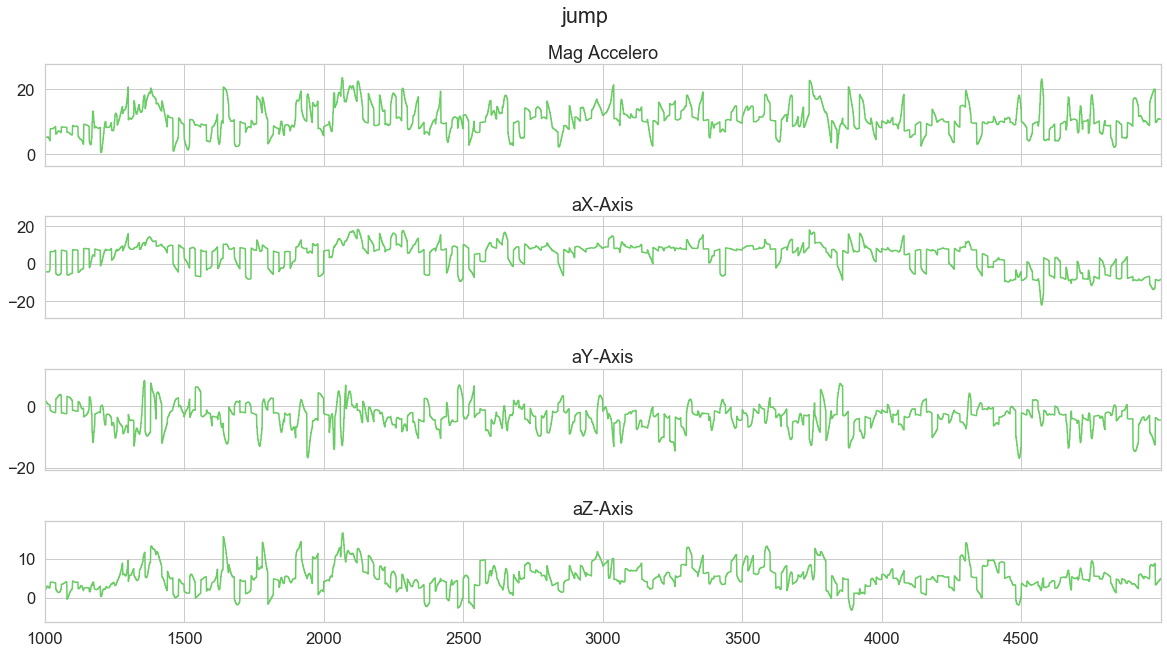

      index        ax        ay        az         ma  label
1000   1000  9.372686  2.947957  0.952343   9.871406  stand
1001   1001  9.346365  2.935993  0.964308   9.844008  stand
1002   1002  9.346365  2.935993  0.964308   9.844008  stand
1003   1003  9.360723  2.935993  0.966700   9.857875  stand
1004   1004  9.360723  2.935993  0.966700   9.857875  stand
...     ...       ...       ...       ...        ...    ...
4995   4995  9.107083 -0.784846  3.919444   9.945702  stand
4996   4996  9.183653 -0.830309  3.924229  10.021401  stand
4997   4997  9.183653 -0.830309  3.924229  10.021401  stand
4998   4998  9.188439 -0.825524  3.936193  10.030081  stand
4999   4999  9.188439 -0.825524  3.936193  10.030081  stand

[4000 rows x 6 columns]
stand


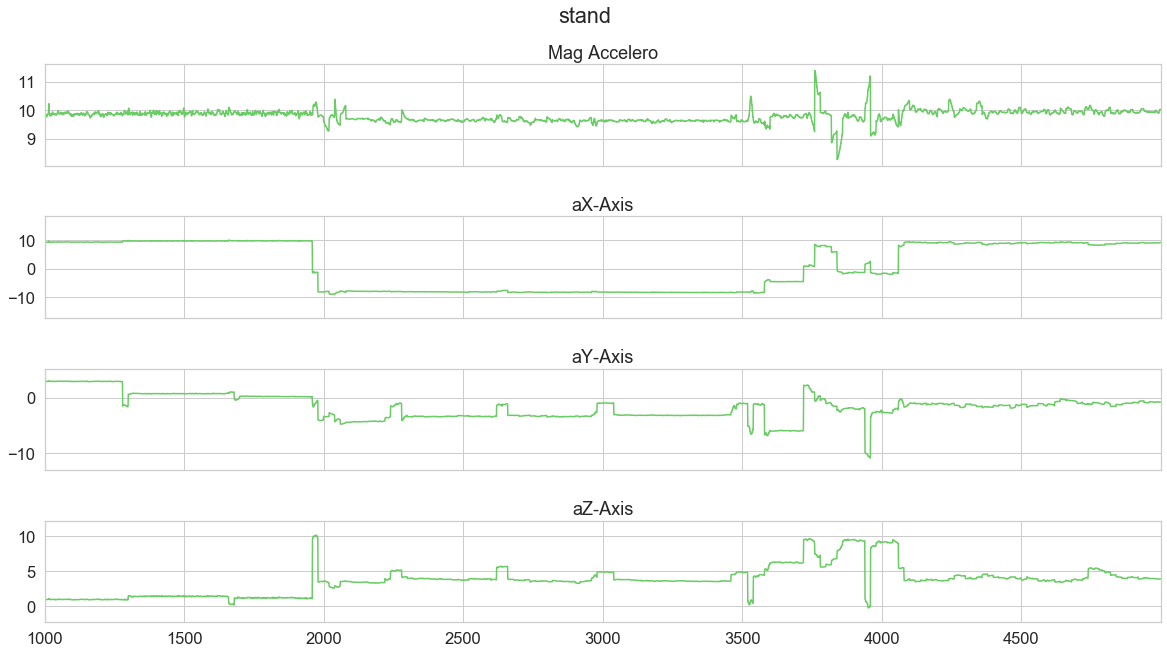

In [229]:
activities = df_plot['label'].value_counts().index
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(nrows=4, figsize=(20, 10), sharex=True)
    plot_axis(ax0, data['index'], data['ma'], 'Mag Accelero')
    plot_axis(ax1, data['index'], data['ax'], 'aX-Axis')
    plot_axis(ax2, data['index'], data['ay'], 'aY-Axis')
    plot_axis(ax3, data['index'], data['az'], 'aZ-Axis')
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
#     ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
Fs=200
for activity in activities:
    data_for_plot = df_plot[(df_plot['label'] == activity)][1000:5000]
    print(data_for_plot)
    print(activity)
    plot_activity(activity, data_for_plot)

# Split training and testing data

In [230]:
def train_test_split(label, ratio):
    split_point = int(len(df[df.label == label]) * ratio)
    return (df[df.label == label].iloc[:split_point, :], df[df.label == label].iloc[split_point:, :])

split_ratio = 0.9
train_data = pd.DataFrame([])
test_data = pd.DataFrame([])

for i in range(len(interesting_labels)):
    (train, test) = train_test_split(interesting_labels[i], split_ratio)
    train_data = pd.concat([train_data, train])
    test_data = pd.concat([test_data, test])

#print("Number of train samples/label: ", len(train_stand))
#print("Number of test samples/label: ", len(test_stand))

# train_data = train_data.iloc[18:,]
# test_data = test_data.iloc[74:,]
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))

#train_label = train_data.iloc[:, 12]
#test_label = test_data.iloc[:, 12]
#train_label = train_label.to_frame()
#test_label = test_label.to_frame()

train_label = train_data['label'].to_frame()
test_label = test_data['label'].to_frame()

Number of train samples:  53388
Number of test samples:  5932


# Data Segmentation (Sliding Window)

In [231]:
N_TIME_STEPS = 100 #sliding window length
STEP = 20 #Sliding window step size
N_FEATURES = 4


def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['ax'].values[i: i + n_time_steps]
        ay = x['ay'].values[i: i + n_time_steps]
        az = x['az'].values[i: i + n_time_steps]

#         lx = x['lx'].values[i: i + n_time_steps]
#         ly = x['ly'].values[i: i + n_time_steps]
#         lz = x['lz'].values[i: i + n_time_steps]
        
#         gx = x['gx'].values[i: i + n_time_steps]
#         gy = x['gy'].values[i: i + n_time_steps]
#         gz = x['gz'].values[i: i + n_time_steps]

#         mx = x['mx'].values[i: i + n_time_steps]
#         my = x['my'].values[i: i + n_time_steps]
#         mz = x['mz'].values[i: i + n_time_steps]
        
        ma =  x['ma'].values[i: i + n_time_steps]
#         mg =  x['mg'].values[i: i + n_time_steps]
#         ml =  x['ml'].values[i: i + n_time_steps]
#         mm =  x['mm'].values[i: i + n_time_steps]
                
        label = stats.mode(y['label'][i: i + n_time_steps])[0][0]
#         segments.append([ax, ay, az, gx, gy, gz, lx, ly, lz, mx, my, mz, ma, mg, ml, mm])
#         segments.append([ax, ay, az, gx, gy, gz, mx, my, mz])
#         segments.append([ax, ay, az,gx, gy,gz,mg])
        segments.append([ax,  ay, az,ma])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_data, train_label, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_data, test_label, N_TIME_STEPS, STEP)

In [232]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [233]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# Import DL Library

In [234]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Bidirectional
from tensorflow.keras.layers import Attention
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import optimizers
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

N_CLASSES = 4
N_HIDDEN_UNITS = 64
L2 = 0.000001

# LSTM Model (Training) 

In [235]:
class attention():
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [239]:
# LSTM model
from keras.backend import clear_session

clear_session()
model = Sequential()
# model.add(Embedding(max_words, emb_dim, input_length=max_len))
# model.add(attention(return_sequences=True)) # receive 3D and output 3D
model.add(LSTM(64, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
         kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2), name="LSTM_1"))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Flatten(name='Flatten'))
model.add(Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"))
model.add(Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2"))

#     LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
#          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#          bias_regularizer=l2(L2), name="LSTM_1"),
#     LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
#          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#          bias_regularizer=l2(L2), name="LSTM_2"),
#     Dropout(0.2),
#     Flatten(name='Flatten'),
#     Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"),
#     Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
# ])

model.summary()

opt = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE = 64
N_EPOCHS = 30

lstm = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 100, 64)           17664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 64)           24832     
_________________________________________________________________
Flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 260       
Total params: 452,420
Trainable params: 452,420
Non-trainable params: 0
_________________________________________________________________
Train on 2665 samples, validate on 292 samples
Epoch 1/30
2665/2665 [==============================] - 16s 6ms/step - loss: 0.8433 - acc

KeyboardInterrupt: 

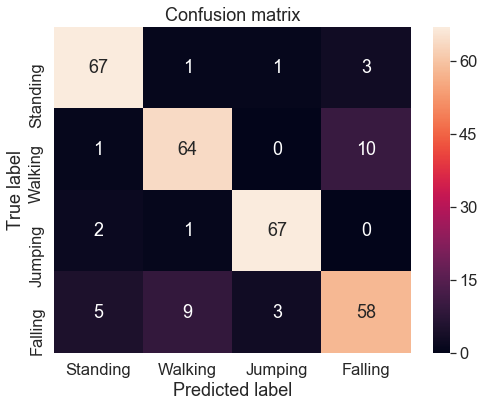

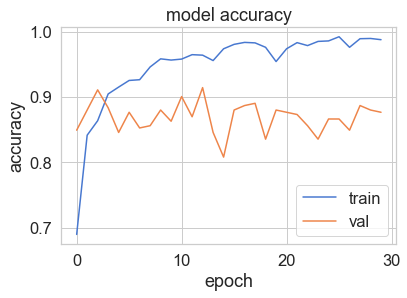

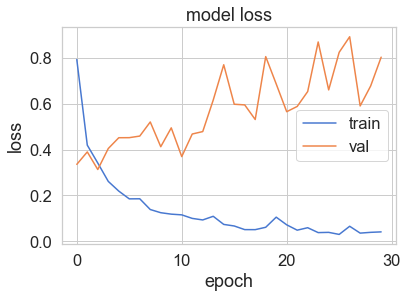

In [237]:
# use LSTM model to predict

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Standing', 'Walking','Jumping','Falling']

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
# plt.ylim((16,14))
plt.xlabel('Predicted label')
plt.show();

plt.plot(lstm.history['acc'])
plt.plot(lstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

# Save the model into .pb file

In [ ]:
N_TIME_STEPS = 180 #sliding window length
STEP = 30 #Sliding window step size
N_FEATURES = 6


In [238]:
# Save LSTM model

output_node_name = "Dense_2/Softmax"
MODEL_LSTM = str(N_TIME_STEPS)+"_"+str(STEP)+"_"+str(N_FEATURES)+"_"+str(N_CLASSES)+"_acc"

tf.train.write_graph(K.get_session().graph_def, './models/LSTM/', \
        MODEL_LSTM + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(K.get_session(), './models/LSTM/' + MODEL_LSTM + '.chkp')

freeze_graph.freeze_graph('./models/LSTM/' +MODEL_LSTM+ '_graph.pbtxt', None, \
    False, './models/LSTM/' + MODEL_LSTM+ '.chkp', output_node_name, \
    "save/restore_all", "save/Const:0", \
    './models/LSTM/' +MODEL_LSTM + '.pb', True, "")



INFO:tensorflow:Restoring parameters from ./models/LSTM/100_20_4_4_acc.chkp
INFO:tensorflow:Froze 7 variables.
INFO:tensorflow:Converted 7 variables to const ops.


node {
  name: "LSTM_1_input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 100
        }
        dim {
          size: 4
        }
      }
    }
  }
}
node {
  name: "LSTM_1/kernel"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 4
          }
          dim {
            size: 256
          }
        }
        tensor_content: "\313&/<\277!\270\275\243>\n\276\244\276\025\276w.\002>{_\224<v\254W=\000\224\016<\003\264\252\275TN\312<\272\334@\274\365\210\371\275t\010\365=\367\3655\275\216Y4>>J2\275\303\245\277\274\254\267\243\275\266%\241\274D\225\227\275\006z\255;S\246\306\274\350\216\324=GV>\275hu\210\275\326\014\014>XS\204=E\250\250\275\263\302\236<\336\3

# CNN Model 

In [ ]:
# from keras.backend import clear_session

# clear_session()
# # CNN model

# model = Sequential()

# model.add(Conv2D(N_HIDDEN_UNITS * 3, kernel_size = 3, input_shape = (X_train.shape[1], X_train.shape[2], 1), padding = 'same',
#                  activation = 'relu', name="Conv2D_Layer1"))
# model.add(Conv2D(N_HIDDEN_UNITS * 2, kernel_size = 3, padding = 'same', activation = 'relu', name="Conv2D_Layer2"))
# model.add(Conv2D(N_HIDDEN_UNITS, kernel_size = 3, padding = 'same', activation = 'relu', name="Conv2D_Layer3"))
# model.add(Flatten(name="Flatten_Layer"))
# model.add(Dense(N_CLASSES, activation = 'softmax', name="CNN_output"))

# model.summary()

# model.compile(optimizer='Adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# BATCH_SIZE = 24
# N_EPOCHS = 100

# cnn = model.fit(np.expand_dims(X_train, axis=-1), y_train,
#                 batch_size=BATCH_SIZE, epochs=N_EPOCHS,
#                 validation_data=(np.expand_dims(X_test, axis=-1), y_test))

In [ ]:
# model.save("model_har.h5")

In [ ]:
# y_pred_ohe = model.predict(np.expand_dims(X_test, axis=-1))
# y_pred_labels = np.argmax(y_pred_ohe, axis=1)
# y_true_labels = np.argmax(y_test, axis=1)
# confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

# LABELS = [ 'standing', 'walking']

# plt.figure(figsize=(8, 6))
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
# plt.title("CNN Result Confusion Matrix")
# plt.ylabel('True label')
# # plt.ylim((16,14))
# plt.xlabel('Predicted label')
# plt.show();

# plt.plot(cnn.history['acc'])
# plt.plot(cnn.history['val_acc'])
# plt.title('CNN model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='best')
# plt.show()

# plt.plot(cnn.history['loss'])
# plt.plot(cnn.history['val_loss'])
# plt.title('CNN model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='best')
# plt.show()

# Save model to .pb file

In [ ]:
# # Save CNN model
# output_node_name = "CNN_output/Softmax"
# MODEL_NAME = "2020_02_09_CNN"

# tf.train.write_graph(K.get_session().graph_def, './models/CNN/', \
#         MODEL_NAME + '_graph.pbtxt')
# saver = tf.train.Saver()
# saver.save(K.get_session(), './models/CNN/' + MODEL_NAME + '.chkp')

# freeze_graph.freeze_graph('./models/CNN/' + MODEL_NAME + '_graph.pbtxt', None, \
#     False, './models/CNN/' + MODEL_NAME + '.chkp', output_node_name, \
#     "save/restore_all", "save/Const:0", \
#     './models/CNN/' + MODEL_NAME + '.pb', True, "")

# Convert .pb to tflite

In [ ]:
# import tensorflow as tf
# # model_dir='./models/CNN/2020_02_09_CNN.pb'
# model_dir='model_har.h5'

# input_arrays = ['Conv2D_Layer1_input']
# output_arrays = ['CNN_output/Softmax']

# tfc = tf.lite.TFLiteConverter.from_keras_model_file(model_dir)
# # converter =  tfc.from_keras_model_file(model_dir, input_arrays, output_arrays)

# tflite_model = tfc.convert()
# open("CNN_model.tflite","wb").write(tflite_model)

# Make sure the model output and input name

In [ ]:
# import tensorflow as tf
# gf = tf.GraphDef()   
# m_file = open(r"D:\Human Activity Recognition\Training\models\LSTM\100_12_walk_stand.pb",'rb')
# gf.ParseFromString(m_file.read())

# with open('somefile.txt', 'a') as the_file:
#     for n in gf.node:
#         the_file.write(n.name+'\n')

# file = open('somefile.txt','r')
# data = file.readlines()
# print ("output name = ")
# print (data[len(data)-1])

# print ("Input name = ")
# file.seek ( 0 )
# print (file.readline())